# Load in test data and trained models

setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import keras
from joblib import dump, load
import numpy as np
from sklearn.preprocessing import StandardScaler

%matplotlib inline

skip = True

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Archie_Short_CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.DS_Store', 'Personal_Dataset', 'Models', 'CW_Dataset', 'Code', 'test_functions.ipynb']


In [ ]:
#Load in models 
hog_lbp_rsvm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','RSVM.joblib'))
hog_lbp_rf = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','random_forest.joblib'))
hog_lbp_cnn = keras.models.load_model(os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_Model'))

In [ ]:
#load in data 
TEST_FOLDER = os.path.join(GOOGLE_DRIVE_PATH,'CW_Dataset/test')
tData = pd.read_csv(os.path.join(TEST_FOLDER,"test_data_refined.csv"))
testData = tData.to_numpy()

In [ ]:
#length of training data
print(testData.shape) 

def formatTraining(trainingData):
  labels = []
  formattedTraining = []
  for sample in trainingData:
    labels.append(sample[len(sample)-1])
    sample = sample[:-1]; sample 
    formattedTraining.append(sample) 


  return formattedTraining, labels

x,y = formatTraining(testData)


(3068, 8501)


In [ ]:
#Reshape data for CNN
import tensorflow as tf
scaler = StandardScaler()
pre_cnn_x = scaler.fit_transform(x)
cnn_x = tf.reshape(pre_cnn_x,(3068,8500,1))
print(type(x))
print(type(cnn_x))


def convert_labels(label_array):
  newTrain = []
  for label in label_array:
    label_vector = [0,0,0,0,0,0,0]
    label_vector[int(label)-1] = 1
    newTrain.append(np.array(label_vector))
  return np.array(newTrain) 

cnn_y = convert_labels(y)
print(cnn_y)


<class 'list'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
#Reshape data for RSVM
rsvm_x = scaler.fit_transform(x)

In [ ]:
#Predict with each model 
rsvm_predictions = hog_lbp_rsvm.predict(rsvm_x)
rf_predictions = hog_lbp_rf.predict(x)
cnn_predictions = hog_lbp_cnn.predict(cnn_x, verbose=0)


In [ ]:
#Convert all predictions into the same format 
converted = False
if not converted:
  cnn_predictions=np.argmax(cnn_predictions,axis=1)
  for position, pred in enumerate(cnn_predictions):
    cnn_predictions[position] = pred +1

print(rsvm_predictions)
print(rf_predictions)
print(cnn_predictions)

[7 5 4 ... 7 5 5]
[7 5 4 ... 7 7 4]
[1 5 4 ... 7 4 4]


# Performance Metrics

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
#reference https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#RSVM Metrics
print("CNN Report")
print(classification_report(cnn_predictions,y,zero_division=1))
print("Random Forest Report")
print(classification_report(rf_predictions,y,zero_division=1))
print("RSVM Report")
print(classification_report(rsvm_predictions,y,zero_division=1))


CNN Report
              precision    recall  f1-score   support

           1       0.13      0.14      0.13       328
           2       0.00      0.00      0.00        51
           3       0.01      0.01      0.01        90
           4       0.41      0.60      0.49      1337
           5       0.18      0.17      0.18       489
           6       0.07      0.10      0.09       135
           7       1.00      0.00      0.00       638

    accuracy                           0.31      3068
   macro avg       0.26      0.15      0.13      3068
weighted avg       0.43      0.31      0.26      3068

Random Forest Report
              precision    recall  f1-score   support

         1.0       0.06      0.13      0.08       164
         2.0       0.00      1.00      0.00         0
         3.0       0.00      0.00      0.00         1
         4.0       0.56      0.60      0.58      1793
         5.0       0.07      0.19      0.10       160
         6.0       0.02      0.13      0.04   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


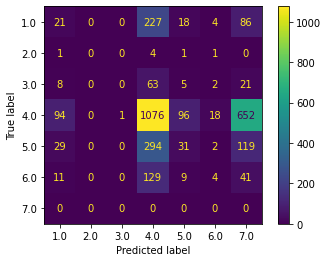

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(hog_lbp_rf, x, y)  
plt.show()

[[  21    1    8   94   29   11    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0]
 [ 227    4   63 1076  294  129    0]
 [  18    1    5   96   31    9    0]
 [   4    1    2   18    2    4    0]
 [  86    0   21  652  119   41    0]]


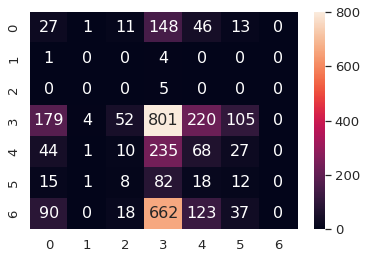

In [ ]:
#reference https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix 
import seaborn as sn
sn.set(font_scale = 1.2) # for label size
cf = confusion_matrix(rf_predictions,y)
print(cf)
cf_cnn = confusion_matrix(cnn_predictions,y)
cf_svm = confusion_matrix(rsvm_predictions,y)
sn.heatmap(cf_svm, annot=True, annot_kws={"size": 16}, fmt='g') # font size




